# **Enunciado**

## José Daniel Sarmiento Blanco 2192232

Design a heat exchanger to be used as a crude oil cooler. 120 kg/s of crude oil enters to the heat exchanger at 102°C and leaves at 65°C. The coolant to be used is city water entering the tube side at 21°C with a flow rate of 65 kg/s. Pressure drop for the crude oil is limited to 150 kPa.

## Importar librerías necesarias

In [1]:
from pyfluids import Fluid, FluidsList, Input, Mixture
from core import ThermoFormules
import numpy as np
from pprint import pprint
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

## Establecer valores conocidos

In [2]:
caudal_crudo                = 120 # kg/s
temperatura_entrada_crudo   = 102 # ºC
temperatura_salida_crudo    = 65  # ºC

temperatura_entrada_agua    = 21  # ºC
caudal_agua                 = 65  # kg/s

presion_limite_crudo        = 150_000 # Pa

<p align="center">
  <img src="./diagrama.jpeg" height ="600px">
</p>

### Se establece un intervalo de temperaturas sugeridas

In [3]:
temperaturas_crudo_salidas = np.arange(60, 90)
temperaturas_crudo_salidas

array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89])

## 0. Establecer valores pre-diseño

In [4]:
k_material                            = 60    # W/ m * k
diametro_interior                     = 16e-3 # m
diametro_exterior                     = 19e-3 # m

longitud                              = 4 #m               

In [5]:
water = Fluid(FluidsList.Water)
water.name

Water

### 0.1 Suposición

[presión agua](https://blog.verti.es/hogar/presion-agua-casa/#:~:text=Lo%20habitual%20es%20que%20la,tengamos%20una%20presión%20u%20otra.)


- Considere como material el acero al carbono, k = 60 W/m*k.
- Diámetro de tubo de 3/4 in ( 19 mm exterior y 16 mm interior ).
- Longitud de 4m

In [6]:
presion_agua  = (2) * 101_325 # Pa
presion_crudo = 413_000       # Pa

### Composición del crudo

In [7]:
components = [FluidsList.nHexane, FluidsList.nOctane, FluidsList.nDecane]
fractions = [30, 40, 30]
mixture = dict(zip(components, fractions))
mixture

{nHexane: 30, nOctane: 40, nDecane: 30}

In [8]:
crudo = Mixture(
    components,
    fractions=fractions,
)

In [9]:
temperatura_propiedades_crudo = (temperatura_entrada_crudo + temperatura_salida_crudo) / 2
print(f"Temperatura de crudo {temperatura_propiedades_crudo} ºC") #+ 273.15)

cp_propiedades_crudo =  0.83 * 1000   # J/kg k
print(f"Calor especifico crudo {cp_propiedades_crudo} J/(kg*k)")

Temperatura de crudo 83.5 ºC
Calor especifico crudo 830.0 J/(kg*k)


In [10]:
temperaturas_propiedades_crudo = (temperaturas_crudo_salidas + temperatura_entrada_crudo) / 2
temperaturas_propiedades_crudo

array([81. , 81.5, 82. , 82.5, 83. , 83.5, 84. , 84.5, 85. , 85.5, 86. ,
       86.5, 87. , 87.5, 88. , 88.5, 89. , 89.5, 90. , 90.5, 91. , 91.5,
       92. , 92.5, 93. , 93.5, 94. , 94.5, 95. , 95.5])

## 1. Termodinámica

$$ \dot{Q} = (\dot{m} *C_{p})_{crudo} * (T_{c1} -T_{c2})$$

In [11]:
calor = caudal_crudo * cp_propiedades_crudo * (temperatura_entrada_crudo - temperatura_salida_crudo ) 
print(f"El calor transferido = {calor} W")

El calor transferido = 3685200.0 W


In [12]:
calores_transferencia = caudal_crudo * cp_propiedades_crudo * (temperatura_entrada_crudo - temperaturas_crudo_salidas)
calores_transferencia

array([4183200., 4083600., 3984000., 3884400., 3784800., 3685200.,
       3585600., 3486000., 3386400., 3286800., 3187200., 3087600.,
       2988000., 2888400., 2788800., 2689200., 2589600., 2490000.,
       2390400., 2290800., 2191200., 2091600., 1992000., 1892400.,
       1792800., 1693200., 1593600., 1494000., 1394400., 1294800.])

In [13]:
estado_agua_propiedades = water.with_state(
    Input.pressure(presion_agua),
    Input.temperature(34),
)
print(estado_agua_propiedades.as_dict())

{'compressibility': 0.0014376012709739205, 'conductivity': 0.6203366408703609, 'critical_pressure': 22064000.0, 'critical_temperature': 373.946, 'density': 994.417937160409, 'dynamic_viscosity': 0.0007337301352239351, 'enthalpy': 142631.9153801642, 'entropy': 491.47808690964223, 'fraction': 100, 'freezing_temperature': None, 'internal_energy': 142428.1278251999, 'kinematic_viscosity': 7.378488538924831e-07, 'max_pressure': 1000000000.0, 'max_temperature': 1726.85, 'min_pressure': 611.6548008968684, 'min_temperature': 0.010000000000047748, 'molar_mass': 0.018015268, 'name': Water, 'phase': Liquid, 'prandtl': 4.942945501085879, 'pressure': 202650, 'quality': None, 'sound_speed': 1518.0155752419128, 'specific_heat': 4179.043576032273, 'specific_volume': 0.0010056133971753675, 'surface_tension': None, 'temperature': 34.0, 'triple_pressure': 611.6548008968684, 'triple_temperature': 0.010000000000047748, 'units_system': SIWithCelsiusAndPercents}


In [14]:
cp_agua                         = estado_agua_propiedades.specific_heat # J /kg k
viscosidad_dinamica_agua        = estado_agua_propiedades.dynamic_viscosity # Pa * s
densidad_agua                   = estado_agua_propiedades.density # kg / m3
k_agua                          = estado_agua_propiedades.conductivity # W / m k
prandl_agua                     = estado_agua_propiedades.prandtl

$$ \dot{Q} = (\dot{m} *C_{p})_{agua} * (T_{w1} - T_{w2})$$

In [15]:
temperatura_salida_agua = temperatura_entrada_agua + calor / (caudal_agua * cp_agua)
print(f"la temperatura de lsa salida del agua del agua es: {temperatura_salida_agua:.2f}")

la temperatura de lsa salida del agua del agua es: 34.57


In [16]:
temperaturas_salida_agua = temperatura_entrada_agua + calores_transferencia / (caudal_agua * cp_agua)
temperaturas_salida_agua

array([36.39991673, 36.03325204, 35.66658736, 35.29992268, 34.93325799,
       34.56659331, 34.19992862, 33.83326394, 33.46659926, 33.09993457,
       32.73326989, 32.3666052 , 31.99994052, 31.63327584, 31.26661115,
       30.89994647, 30.53328178, 30.1666171 , 29.79995242, 29.43328773,
       29.06662305, 28.69995836, 28.33329368, 27.966629  , 27.59996431,
       27.23329963, 26.86663494, 26.49997026, 26.13330558, 25.76664089])

## 2. Transferencia de calor

<p align="center">
  <img src="./resistencia.jpeg" height ="200px">
</p>

### 2.1 Calculo de una U estimada

Asuma los coeficiente de trasferencia de calor

$$ \frac{1}{U_{ensuciamiento}} = \frac{r_{0}}{r_{i}} \frac{1}{h_{i}} + \frac{r_{0}}{r_{1}}*R_{f_{}i} + r_{0} \frac{ln(\frac{r_{0}}{r_{i}} )}{k} + R_{f_{}o} + \frac{1}{h_{0}} $$



$$ \frac{1}{U_{limpio}} = \frac{r_{0}}{r_{i}} \frac{1}{h_{i}} + r_{0} \frac{ln(\frac{r_{0}}{r_{i}} )}{k} + \frac{1}{h_{0}}$$

En este caso
- $ r_{0} $ -> radio exterior
- $ r_{i} $ -> radio interior

- $ h_{0} $ -> coeficiente de convección en la carcasa
- $ h_{i} $ -> coeficiente de convección en el tubo

In [17]:
h_agua    = 4000     # kj/kg * k
h_crudo   = 800      # kj/kg * k

R_f_crudo = 0.000352 # m2 k/w
R_f_agua  = 0.000176 # m2 k/w

In [18]:
U_ensuciamiento = (
    (diametro_exterior / diametro_interior) * 1 / h_agua
    + (diametro_exterior / diametro_interior) * R_f_agua
    + (diametro_exterior / 2) * np.log(diametro_exterior/diametro_interior) / k_material
    + R_f_crudo
    + 1 / h_crudo
) ** -1 
U_ensuciamiento

468.36551055305137

In [19]:
U_no_ensuciamiento = (
    (diametro_exterior / diametro_interior) * 1 / h_agua
    + (diametro_exterior / 2) * np.log(diametro_exterior/diametro_interior) / k_material
    + 1 / h_crudo
) ** -1 
U_no_ensuciamiento

635.2898597346917

### 2.2 Calculo de la diferencia media logarítmica

In [20]:
diferencia_temperatura_1 = temperatura_entrada_crudo - temperatura_salida_agua
diferencia_temperatura_2 = temperatura_salida_crudo - temperatura_entrada_agua
print(f"diferencia de temperatura sección 1: {diferencia_temperatura_1:.2f} ºC" )
print(f"diferencia de temperatura sección 2: {diferencia_temperatura_2:.2f} ºC" )

diferencia_log_temperatura = (diferencia_temperatura_2 - diferencia_temperatura_1)/ np.log(diferencia_temperatura_2/diferencia_temperatura_1)
print(f"diferencia media logarítmica: {diferencia_log_temperatura:.2f} ºC")

diferencia de temperatura sección 1: 67.43 ºC
diferencia de temperatura sección 2: 44.00 ºC
diferencia media logarítmica: 54.89 ºC


In [21]:
diferencia_temperatura_crudo = temperatura_entrada_crudo - temperaturas_crudo_salidas
diferencia_temperatura_crudo

diferencia_log_temperaturas = (diferencia_temperatura_2 - diferencia_temperatura_crudo) / np.log(diferencia_temperatura_2/diferencia_temperatura_crudo)
diferencia_log_temperaturas

array([42.99224694, 42.48234708, 41.96823475, 41.44975052, 40.92672451,
       40.39897537, 39.86630924, 39.32851844, 38.78538008, 38.23665446,
       37.68208323, 37.12138725, 36.55426426, 35.98038603, 35.39939516,
       34.81090129, 34.21447675, 33.6096513 , 32.995906  , 32.37266584,
       31.7392909 , 31.09506562, 30.43918569, 29.7707419 , 29.08869994,
       28.39187505, 27.67889953, 26.9481808 , 26.19784621, 25.42566925])

Para el calculo de las el factor de correction se uso las tables del metodo de lmtd del moodle 

In [22]:
R = (temperatura_entrada_crudo - temperatura_salida_crudo) / (temperatura_salida_agua- temperatura_entrada_agua)
P = 1 / R
print({"R":R, "P":P})

{'R': 2.727287474318251, 'P': 0.36666468401904473}


Teniendo en cuenta las gráficas de moodle

In [23]:
F = 0.86

In [24]:
diferencia_log_temperatura_corregida = F * diferencia_log_temperatura
print(f"Diferencia de temperatura logar ítmica {diferencia_log_temperatura_corregida:.2f} ºC")

Diferencia de temperatura logar ítmica 47.20 ºC


### 2.3 Calculo de la relación de area

In [25]:
A_f = calor / (U_ensuciamiento * diferencia_log_temperatura_corregida)
A_c = calor / (U_no_ensuciamiento * diferencia_log_temperatura_corregida)

print(f"Area con ensuciamiento {A_f} m^2")
print(f"Area sin ensuciamiento {A_c} m^2")

area_ratio =  A_f / A_c - 1
print(f"Relación de area ratio: {area_ratio:.4f}")

Area con ensuciamiento 166.69409566996808 m^2
Area sin ensuciamiento 122.89471337894294 m^2
Relación de area ratio: 0.3564


Se toma como referencia las siguientes dimisiones y parámetros de diseño en base a los valores estándares

In [26]:
Cl         = 1
L          = 4   # m ; Es la longitud 
CTP        = 0.93 # One tube pass
PitchRatio = 1.25

In [27]:
diametro_carcasa = 0.637 * ((Cl / CTP) * A_f * pow(PitchRatio, 2) * diametro_exterior / L)**(1/2) 
print(f"El diámetro de la carcasa {diametro_carcasa:.5f} m")

diametro_carcasa = 0.75 # Se aproxima al estándar
print(f"El diámetro de la carcasa estándar {diametro_carcasa} m")

El diámetro de la carcasa 0.73471 m
El diámetro de la carcasa estándar 0.75 m


In [28]:
numeros_tubos = 0.785 * (CTP/Cl) * (diametro_carcasa)**2 /((PitchRatio * diametro_exterior)**2)
print(numeros_tubos)

728.0277008310251


Se supone un 60 %  del diámetro de la carcasa

In [29]:
B = 0.6 * diametro_carcasa
print('espacio entre baffle', B)
B = 0.5
print('espacio entre baffle', B)

espacio entre baffle 0.44999999999999996
espacio entre baffle 0.5


## 3. Corrección método de kern

### 3.1 Calculo del diámetro equivalente

In [30]:
numeros_tubos = 749  # Estándar

In [31]:
Pitch_Size              = 0.0254 # m -> Note que esta valor sale en las tablas como 1 in

In [32]:
D_e = 4 * (Pitch_Size ** 2 - np.pi * (diametro_exterior**2) / 4) / (np.pi * diametro_exterior)
print(f"calculo del diámetro equivalente del lado del tubo {D_e:.4f} m")

calculo del diámetro equivalente del lado del tubo 0.0242 m


### 3.2 Calculo de la velocidad másica

In [33]:
C = Pitch_Size - diametro_exterior
print(f"Holgura {C:.5f}")

Holgura 0.00640


In [34]:
A_s = (diametro_carcasa * C * B) / Pitch_Size
print(f"Area de flujo cruzado {A_s:4f} m")

Area de flujo cruzado 0.094488 m


In [35]:
G_s = caudal_crudo / A_s
print(f"Velocidad másica {G_s:.2f} kg/(s*m2)")

Velocidad másica 1270.00 kg/(s*m2)


### 3.3 Calculo coeficiente convectivo crudo

In [36]:
estado_crudo =  crudo.with_state(
    Input.pressure(presion_crudo),
    Input.temperature(temperatura_propiedades_crudo),
)
densidad_crudo_kern            = estado_crudo.density
cp_crudo_kern                  = estado_crudo.specific_heat
viscosidad_dinamica_crudo_kern = 0.001
k_crudo_kern                   = estado_crudo.conductivity
prandtl_crudo_kern             = estado_crudo.prandtl

print(
    densidad_crudo_kern, cp_crudo_kern, viscosidad_dinamica_crudo_kern, 
    k_crudo_kern, 
    prandtl_crudo_kern
)

642.6441899127288 2466.207461427457 0.001 0.1241829206400716 6.97657968990968


In [37]:
Re_crudo = G_s * D_e / viscosidad_dinamica_crudo_kern
print(f'Reynolds crudo: {Re_crudo:.2f}')

Reynolds crudo: 30776.99


In [38]:
h_crudo = 0.36 * (D_e * G_s / viscosidad_dinamica_crudo_kern)**0.55 \
    * (cp_crudo_kern * viscosidad_dinamica_crudo_kern / k_crudo_kern)**(1/3) \
    * (viscosidad_dinamica_crudo_kern / viscosidad_dinamica_agua)**0.14 \
    * k_crudo_kern / D_e
print(f'Coeficiente de convección del crudo {h_crudo:.2f} W/(m^2 k)')

Coeficiente de convección del crudo 1534.43 W/(m^2 k)


### 3.4 Calculo coeficiente convectivo Agua

In [39]:
T_w = 1/2 * (
    (temperatura_entrada_agua + temperatura_salida_agua) / 2 +
    (temperatura_entrada_crudo + temperatura_salida_crudo) / 2
)
print(f'Temperatura promedio {T_w:.2f} ºC')

Temperatura promedio 55.64 ºC


In [40]:
estado_agua_kern = water.with_state(
    Input.pressure(presion_agua),
    Input.temperature(T_w),
)
densidad_agua_kern            = estado_agua_kern.density
cp_agua_kern                  = estado_agua_kern.specific_heat
viscosidad_dinamica_agua_kern = estado_agua_kern.dynamic_viscosity
k_agua_kern                   = estado_agua_kern.conductivity
prandtl_agua_kern             = estado_agua_kern.prandtl

print(estado_agua_kern.as_dict())
print(
    densidad_agua_kern, cp_agua_kern, 
    viscosidad_dinamica_agua_kern, k_agua_kern, 
    prandtl_agua_kern
)

{'compressibility': 0.0013552312320620485, 'conductivity': 0.6467357483177187, 'critical_pressure': 22064000.0, 'critical_temperature': 373.946, 'density': 985.4253674034841, 'dynamic_viscosity': 0.0004985467955942873, 'enthalpy': 233099.21479641055, 'entropy': 776.1009136555505, 'fraction': 100, 'freezing_temperature': None, 'internal_energy': 232893.56756356746, 'kinematic_viscosity': 5.059203995406752e-07, 'max_pressure': 1000000000.0, 'max_temperature': 1726.85, 'min_pressure': 611.6548008968684, 'min_temperature': 0.010000000000047748, 'molar_mass': 0.018015268, 'name': Water, 'phase': Liquid, 'prandtl': 3.2245057186580506, 'pressure': 202650, 'quality': None, 'sound_speed': 1548.1033156097012, 'specific_heat': 4182.963640203917, 'specific_volume': 0.0010147901942436483, 'surface_tension': None, 'temperature': 55.64164832717614, 'triple_pressure': 611.6548008968684, 'triple_temperature': 0.010000000000047748, 'units_system': SIWithCelsiusAndPercents}
985.4253674034841 4182.9636402

In [41]:
A_tp = np.pi * diametro_interior**2/4 * numeros_tubos / 2 
print(f"Area de transferencia por tubo {A_tp:.5f} m^2")

Area de transferencia por tubo 0.07530 m^2


In [42]:
u_m_agua = caudal_agua / (densidad_agua_kern * A_tp)
print(f"Velocidad media agua {u_m_agua:.2f} (m/s)")

Velocidad media agua 0.88 (m/s)


In [43]:
Re_agua = densidad_agua_kern * u_m_agua * diametro_interior / viscosidad_dinamica_crudo_kern
print(f"Reynolds agua {Re_agua:.2f}")

Reynolds agua 13811.84


#### Como el fluido es turbulento se usa correlación de  Grielinki's

In [44]:
f = (1.58*np.log(Re_agua) - 3.28)**-2
f

0.007203089676605395

In [45]:
Nu_b = (f/2)*(Re_agua - 1000)*prandtl_agua_kern/(1 + 12.7*(f/2)**(1/2)*(prandtl_agua_kern**(2/3) - 1))
Nu_b

78.25353545792119

In [46]:
h_agua = Nu_b * k_agua_kern / diametro_interior
print(f"Coeficiente de convección agua {h_agua:.2f} W/(m^2 * k)")

Coeficiente de convección agua 3163.08 W/(m^2 * k)


### 3.5 Corrección del area

In [47]:
U_ensuciamiento_real = (
    (diametro_exterior / diametro_interior) * 1 / h_agua
    + (diametro_exterior / diametro_interior) * R_f_agua
    + (diametro_exterior / 2) * np.log(diametro_exterior/diametro_interior) / k_material
    + R_f_crudo
    + 1 / h_crudo
) ** -1 
U_ensuciamiento_real

619.0639513494093

In [48]:
U_no_ensuciamiento_real = (
    (diametro_exterior / diametro_interior) * 1 / h_agua
    + (diametro_exterior / 2) * np.log(diametro_exterior/diametro_interior) / k_material
    + 1 / h_crudo
) ** -1 
U_no_ensuciamiento_real

948.4588511059204

In [49]:
f = np.e**(0.576 - 0.19*np.log(Re_agua))
print(f)

N_b = longitud / B - 1 
print(N_b)

sigma = (viscosidad_dinamica_agua_kern / viscosidad_dinamica_crudo_kern)**0.14
print(sigma)

diferencia_presion = f * G_s ** 2 * (N_b + 1) * 0.39 / (sigma * 2 * densidad_agua_kern * D_e)
print(f"La diferencia de presión: {diferencia_presion:.2f} Pa")

0.29074068154671007
7.0
0.9071494259564794
La diferencia de presión: 33768.58 Pa


In [50]:
area = calor /(U_ensuciamiento_real * diferencia_log_temperatura)
print(f"El area de transferencia de calor: {area:.2f} m^2")
area_ft = area * 10.764
print(f"El area de transferencia de calor: {area_ft:.2f} ft^2")

El area de transferencia de calor: 108.46 m^2
El area de transferencia de calor: 1167.46 ft^2


In [51]:
areas = calores_transferencia / (U_ensuciamiento_real * diferencia_log_temperaturas)
areas = areas[::4]
areas_ft = areas * 10.764
areas_ft

array([1691.82975518, 1607.95585218, 1518.1279549 , 1421.28351773,
       1316.01535761, 1200.39167042, 1071.63207846,  925.46491588])

In [63]:
data_bo_map = list(map(
    lambda x,y,t : (x,y,t),
    areas_ft.tolist(),
    [78600, 75300, 71700, 67800, 63500, 58800, 53400, 47100],
    temperaturas_crudo_salidas[::4].tolist()
))
data_bo_map

[(1691.8297551791425, 78600, 60),
 (1607.9558521765307, 75300, 64),
 (1518.1279549013298, 71700, 68),
 (1421.283517727997, 67800, 72),
 (1316.0153576096095, 63500, 76),
 (1200.3916704151268, 58800, 80),
 (1071.6320784641866, 53400, 84),
 (925.4649158818945, 47100, 88)]

In [64]:
data = pd.DataFrame(
    data_bo_map,
    columns=['area', 'costo_total', 'temperatura']
)
data.head()

,area,costo_total,temperatura
0,1691.829755,78600,60
1,1607.955852,75300,64
2,1518.127955,71700,68
3,1421.283518,67800,72
4,1316.015358,63500,76


In [54]:
data['costo_especifico'] = data['costo_total'] / data['area']
data.head()

,area,costo_total,costo_especifico
0,1691.829755,78600,46.458575
1,1607.955852,75300,46.829644
2,1518.127955,71700,47.229221
3,1421.283518,67800,47.703360
4,1316.015358,63500,48.251717


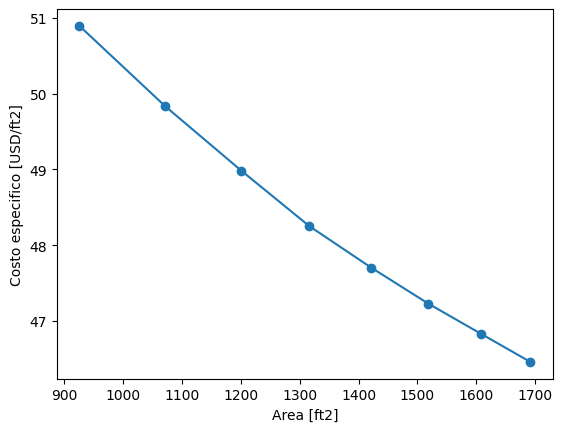

In [56]:
plt.plot(
    data['area'],
    data['costo_especifico'],
    marker='o'
)
plt.xlabel('Area [ft2]')
plt.ylabel('Costo especifico [USD/ft2]')
plt.grid(False)
plt.show()

In [57]:
# Define the power law function
def power_law(x, A, B):
    return A * (x ** B)

In [58]:
# Perform curve fitting to find A and B
params, covariance = curve_fit(
    power_law, 
    data['area'].to_numpy(),
    data["costo_especifico"].to_numpy()
)

In [59]:
# Extract the values of A and B
K, n = params

m = 1 + n
print("k =", K)
print("m =", m)
print("n =", n)

k = 143.71097312414693
m = 0.8481049794138176
n = -0.15189502058618237


In [70]:
data['costo_intercambiador'] =  K * (data['area'] ** (m))
data.head()

,area,costo_total,temperatura,costo_intercambiado,costo_intercambiador
0,1691.829755,78600,60,78609.545968,78609.545968
1,1607.955852,75300,64,75291.678180,75291.678180
2,1518.127955,71700,68,71708.957063,71708.957063
3,1421.283518,67800,72,67810.062868,67810.062868
4,1316.015358,63500,76,63525.878593,63525.878593


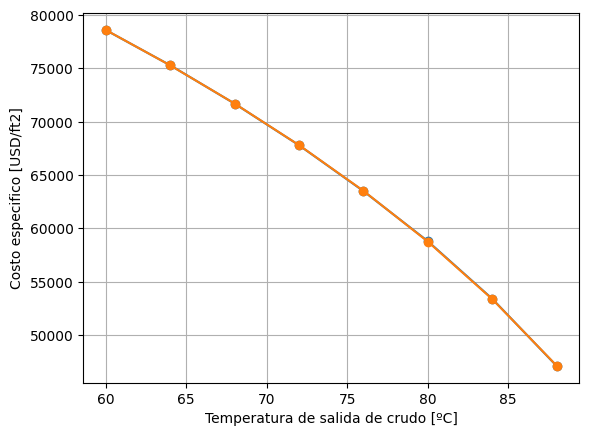

In [71]:
plt.plot(
    data['temperatura'],
    data['costo_total'],
    marker='o'
)
plt.plot(
    data['temperatura'],
    data['costo_intercambiador'],
    marker='o'
)
plt.xlabel('Temperatura de salida de crudo [ºC]')
plt.ylabel('Costo especifico [USD/ft2]')
plt.grid()
plt.show()

## 4. Conclusion

Da una diferencia de presión inferior a 150kpa (33768.58) por ende cumple con los requerimientos


<p align="center">
  <img src="./matches.png" height ="300px">
</p>


### Resultados de la evaluación de diseño

- Material = Acero al carbono k = 60 W/mk
- Longitud del intercambiador = 4 m
- Numero de tubos = 640
- Coeficientes de convección
    - Agua : 5071.76 W/mk
    - Crudo : 2458.236773857342


    

- Diámetro de la carcasa: 0.7 m
- La distribución de los tubos en cuadrada
- Un Pitch_Size de 0.0254 m

- Temperaturas de trabajo
    - Agua :
        - Entrada : 21 º C
        - Salida  : 34.5 º C
    - Crudo :
        - Entrada : 102 ºC
        - Salida  : 65  ºC


## Referencias
- Abdulagatov, I.M., Abdulagatova, Z.Z., Grigor’ev, B.A. et al. Thermal Diffusivity, Heat Capacity, and Thermal Conductivity of Oil Reservoir Rock at High Temperatures. Int J Thermophys 42, 135 (2021). https://doi.org/10.1007/s10765-021-02878-x
- Seguros, V. (2021) Presión del Agua en Casa: Problemas habituales: Blog Verti, Verti Blog. Available at: https://blog.verti.es/hogar/presion-agua-casa/#:~:text=Lo%20habitual%20es%20que%20la,tengamos%20una%20presión%20u%20otra. (Accessed: 13 October 2023). 
- Bell, I.H. et al. (2014) ‘Pure and pseudo-pure fluid thermophysical property evaluation and the open-source Thermophysical Property Library coolprop’, Industrial &amp;amp; Engineering Chemistry Research, 53(6), pp. 2498–2508. doi:10.1021/ie4033999. 